In [12]:
from tensorflow import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K

In [13]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
y_train = np.expand_dims(y_train,axis=1)
y_test = np.expand_dims(y_test,axis=1)
print(y_train.shape,y_test.shape)

(404, 1) (102, 1)


In [14]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [15]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(20 ,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1,activation=keras.activations.softsign))

In [16]:
from tensorflow.keras import backend as K
func = K.function([model.layers[0].input], [model.layers[-2].output])

In [26]:
lrs = []
K1 = 0.
epochs = 1000
batch_size=4
q=0

In [18]:
def lr_schedule(epoch):
    global K1

    Kz = 0.
    
    for i in tqdm(range((len(x_train) - 1) // batch_size + 1)):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
    	
        tmp = np.array(func([xb]))
        activ = np.linalg.norm(tmp)
        
        if activ > Kz:
            Kz = activ
    # print("The value of K_z is ",Kz)
    K1 = (1/batch_size)*(Kz)*max(q,1-q)
    lr = 1 / K1
    lrs.append(lr)
    # print('Epoch', epoch, 'LR =', lr)
    return lr


In [19]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [20]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [21]:
model_upper = models.Sequential()
model_upper.add(layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model_upper.add(layers.Dense(20 ,activation='relu'))
model_upper.add(layers.Dense(1,activation=keras.activations.softsign))
q = 0.95
model_upper.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())

In [22]:
history_upper=model_upper.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

100%|██████████| 101/101 [00:00<00:00, 470.73it/s]


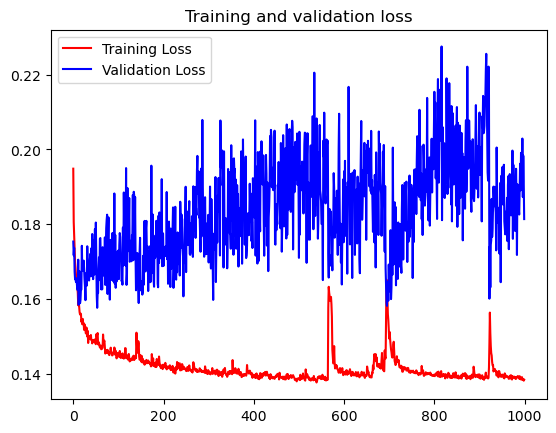

In [23]:
import matplotlib.pyplot as plt
loss = history_upper.history['loss']
val_loss = history_upper.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [24]:
model_lower = models.Sequential()
model_lower.add(layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model_lower.add(layers.Dense(20 ,activation='relu'))
model_lower.add(layers.Dense(1,activation=keras.activations.softsign))
q = 0.05
model_lower.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())

In [27]:
history_lower=model_lower.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size, validation_data=(x_test,y_test),callbacks=[lr_scheduler])

100%|██████████| 101/101 [00:00<00:00, 573.63it/s]


In [ ]:
import matplotlib.pyplot as plt
loss = history_lower.history['loss']
val_loss = history_lower.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [ ]:
plt.figure()
plt.scatter(range(len(y_test)),y_test)
pred_lower = model_lower.predict(x_test)
plt.plot(range(len(y_test)),pred_lower)
pred_upper = model_upper.predict(x_test)
plt.plot(range(len(y_test)),pred_upper)

In [ ]:
model_const1 = models.Sequential()
model_const1.add(layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model_const1.add(layers.Dense(20, activation='relu'))
model_const1.add(layers.Dense(1,activation = keras.activations.softsign))
q = 0.5
model_const1.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())

In [ ]:
history_const1=model_const1.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size*2,validation_data=(x_test,y_test))

In [ ]:
import matplotlib.pyplot as plt
loss = history_const1.history['loss']
val_loss = history_const1.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


In [ ]:
model_const2 = models.Sequential()
model_const2.add(layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model_const2.add(layers.Dense(20, activation='relu'))
model_const2.add(layers.Dense(1,activation = keras.activations.softsign))
q = 0.05
model_const2.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())

In [ ]:
history_const2 =model_const2.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size, validation_data=(x_test,y_test))

In [ ]:
import matplotlib.pyplot as plt
loss = history_const2.history['loss']
val_loss = history_const2.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
loss_const = history_const2.history['loss']
loss_lalr = history_lower.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss_const, 'r', label='Loss Constant')
plt.plot(epochs, loss_lalr, 'b', label='Loss LALR')
plt.title('Loss Comparision for 5th Quantile')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.05,0.1)
plt.legend()
plt.savefig('Training_Loss-Boston_Housing-Q5.png')
plt.show()


In [ ]:
model_const3 = models.Sequential()
model_const3.add(layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model_const3.add(layers.Dense(20, activation='relu'))
model_const3.add(layers.Dense(1,activation = keras.activations.softsign))
q = 0.95
model_const3.compile(loss=lambda y,f: tilted_loss(q,y,f), optimizer=keras.optimizers.SGD())

In [ ]:
history_const3 =model_const3.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size, validation_data=(x_test,y_test))

In [ ]:
import matplotlib.pyplot as plt
loss = history_const3.history['loss']
val_loss = history_const3.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
loss_const = history_const3.history['loss']
loss_lalr = history_upper.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss_const, 'r', label='Loss Constant')
plt.plot(epochs, loss_lalr, 'b', label='Loss LALR')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.13,0.2)
plt.legend()
plt.savefig('Training_Loss-Boston_Housing-Q95.png')
plt.show()
